## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest
import trajectory_msgs.msg
from copy import deepcopy


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [8]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a "dissolving" tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.6):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [24]:

rospy.init_node("recognition")


In [25]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [26]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [27]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
   
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [28]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [29]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [30]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=3
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [31]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [32]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz))
        

In [33]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE



In [35]:
move_base(1.5,1.13,.5*np.pi)

In [36]:
clear_octo_client.call()

In [37]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

#head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly


gaze_point(1.16,1.6,.4)  #center of table 1' ish
#gaze_point(-.03,1.6,0.7)  #center of table 2' ish


('i am at', [1.4780366635336044, 1.0670127916167373, 0.9675519079997384], 83.07899581839892)
('gaze goal', 1.16, 1.6, 0.4)
('relative to robot', (0.3180366635336045, -0.5329872083832627, -59.1752190374757))


True

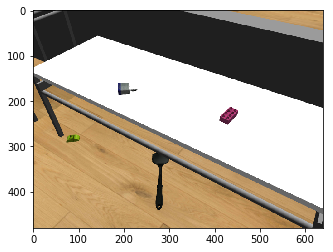

In [38]:
plt.imshow(rgbd.get_image())

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 1, 'objects')
('Plane', 2, 'has', 2, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.31994779, -0.34290308,  0.90956426]), array([ 0.16370873, -0.00124722,  0.81963249]), array([0.14492513, 0.18743966, 0.76791536])]
('images[]', 1)


True

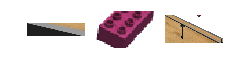

In [39]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats, 'tmc_plane_segmentation')


In [41]:
scene = moveit_commander.PlanningSceneInterface()
scene.remove_world_object()

In [40]:
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'tmc_plane_segmentation', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_tmc',pp ,(.05,.1,.3))
    print i



0
1
2


('cX,cY', 582, 10)
[ 0.9680999  -0.89208424  2.1905687 ]
('cX,cY', 454, 237)
[ 0.20383406 -0.00486212  0.8339917 ]
('cX,cY', 224, 170)
[-0.16545565 -0.12063208  0.9604566 ]
('images[]', 0)
('images[]', 1)
('images[]', 2)
1
2


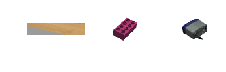

In [42]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'Kmeans_pca')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'Kmeans_pca', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_pca',pp ,(0.3,.1,.05))
    print i


In [43]:
#scene.remove_world_object()

In [44]:
move_base(1.5,1.3,.75*np.pi)


In [45]:
move_base(1.5,1.3,.75*np.pi)


In [46]:
gaze_point(1.16,1.6,.4)  #center of table 1' ish


('i am at', [1.530087437258753, 1.239131548810216, 0.9674875672375427], 137.03714534933047)
('gaze goal', 1.16, 1.6, 0.4)
('relative to robot', (0.37008743725875304, -0.36086845118978417, -44.27741058381578))


True

('Plane', 0, 'has', 4, 'objects')
('Plane', 1, 'has', 1, 'objects')
('Plane', 2, 'has', 0, 'objects')
[array([-0.01605006,  0.07567046,  0.686033  ]), array([-0.10431488, -0.12238912,  0.83200512]), array([-0.0338941 ,  0.11875447,  0.77805796]), array([0.20834459, 0.06501186, 0.67368003]), array([ 0.36006   , -0.29795455,  0.7442906 ])]
('images[]', 1)
('images[]', 3)
1
3


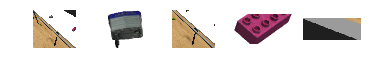

In [47]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats, 'tmc_plane_segmentation_2')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'tmc_plane_segmentation_2', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_tmc_2',pp ,(.3,.1,.01))
    print i




('cX,cY', 304, 380)
[-0.02089461  0.25141776  0.9564989 ]
('cX,cY', 489, 282)
[0.21240097 0.05342837 0.6927023 ]
('cX,cY', 137, 239)
[-4.2239696e-01 -5.1136088e-04  1.2832823e+00]
('cX,cY', 246, 159)
[-0.11183906 -0.12042369  0.84935236]
('cX,cY', 31, 143)
[-0.77045935 -0.25353518  1.4757208 ]
('images[]', 0)
('images[]', 1)
('images[]', 2)
('images[]', 3)
('images[]', 4)
1
3


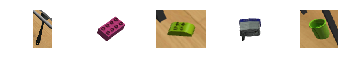

In [48]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'Kmeans_pca_2')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'Kmeans_pca_2', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_pca_2',pp ,(.3,.1,.01))
    print i


In [49]:
move_base(.9,1.3,.35*np.pi)


In [51]:
gaze_point(1.16,1.6,.4)  #center of table 1' ish


('i am at', [0.8597758924047928, 1.2496743675328634, 0.9670263714883998], 65.6110930602108)
('gaze goal', 1.16, 1.6, 0.4)
('relative to robot', (-0.3002241075952071, -0.35032563246713666, -130.59610818276363))


True

In [52]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats, 'tmc_plane_segmentation_3')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'tmc_plane_segmentation_3', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_tmc_3',pp ,(.3,.1,.01))
    print i




ServiceException: transport error completing service call: unable to receive data from sender, check sender's logs for details

('cX,cY', 293, 204)
[-0.03401742 -0.04767192  0.7396654 ]
('images[]', 0)
0


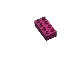

In [54]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'Kmeans_pca_3')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'Kmeans_pca_3', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_pca_3',pp ,(.3,.1,.01))
    print i


In [55]:
##############3

In [56]:
def add_object(name, size, pose, orientation, shape='box'):
    p = PoseStamped()
    p.header.frame_id = "map"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.w = orientation[1] * np.pi

    scene.add_box(name, p, size)

def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4], [2.5, 4.7, 0.78], [0.5, 0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.7, 0.49], [0.5, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.7, 0.18], [0.5, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5, 0.5])
    
    add_object("table_big", [1.7, 0.13, 0.7], [0.95, 1.9, 0.34], [0.5, 0.5])
    add_object("table_small", [0.5, 0.01, 0.4], [0.1, 1.9, 0.61], [0.5, 0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5, 0.5])  
    
    
    return True


In [57]:
p, r =listener.lookupTransform( 'map','Table_Object1Kmeans_pca', rospy.Time(0))
pp=np_2_pose(p,r)
pp.header.frame_id= "map"
scene.add_box('Object2',pp ,(.3,.1,.1))

In [45]:
scene.remove_world_object('Object2')

In [ ]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats, 'tmc_plane segmentation_3')
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'Kmeans_pca_3')


In [58]:
def add_object(name, size, pose, orientation, shape='box'):
    p = PoseStamped()
    p.header.frame_id = "map"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.w = orientation[1] * np.pi

    scene.add_box(name, p, size)

def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4], [2.5, 4.7, 0.78], [0.5, 0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.7, 0.49], [0.5, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.7, 0.18], [0.5, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5, 0.5])
    
    add_object("table_big", [1.7, 0.13, 0.7], [0.95, 1.9, 0.34], [0.5, 0.5])
    add_object("table_small", [0.5, 0.01, 0.4], [0.1, 1.9, 0.61], [0.5, 0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5, 0.5])  
    
    
    return True


In [59]:
publish_scene()


True

In [60]:
# Add an object to objects centroid.( use a convenient shape (box, cilinder and sphere ))
# It is possible to add .dae model objects ( the ones in gzebo YCB object data set for example)

In [61]:
scene.get_objects()

{'Object0_pca_3': header: 
   seq: 0
   stamp: 
     secs: 0
     nsecs:         0
   frame_id: "odom"
 id: "Object0_pca_3"
 type: 
   key: ''
   db: ''
 primitives: 
   - 
     type: 1
     dimensions: [0.3, 0.1, 0.01]
 primitive_poses: 
   - 
     position: 
       x: 1.24274107794
       y: 1.78240025883
       z: 0.404858981809
     orientation: 
       x: 0.251769915602
       y: 0.239215835643
       z: 0.646030295914
       w: 0.679729762727
 meshes: []
 mesh_poses: []
 planes: []
 plane_poses: []
 operation: 0, 'Object1_pca': header: 
   seq: 0
   stamp: 
     secs: 0
     nsecs:         0
   frame_id: "odom"
 id: "Object1_pca"
 type: 
   key: ''
   db: ''
 primitives: 
   - 
     type: 1
     dimensions: [0.3, 0.1, 0.05]
 primitive_poses: 
   - 
     position: 
       x: 1.23666439622
       y: 1.78477290247
       z: 0.404630683505
     orientation: 
       x: -0.537261936262
       y: 0.73537622678
       z: -0.331961741724
       w: 0.24570880929
 meshes: []
 mesh_poses: []

In [62]:
import moveit_msgs.msg


In [63]:
poses = scene.get_object_poses(['Object0_pca_3'])

In [64]:
poses

{'Object0_pca_3': position: 
   x: 1.24274107794
   y: 1.78240025883
   z: 0.404858981809
 orientation: 
   x: 0.251769915602
   y: 0.239215835643
   z: 0.646030295914
   w: 0.679729762727}

In [56]:
g = moveit_msgs.msg.Grasp()

In [57]:
g

id: ''
pre_grasp_posture: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: []
grasp_posture: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  joint_names: []
  points: []
grasp_pose: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: ''
  pose: 
    position: 
      x: 0.0
      y: 0.0
      z: 0.0
    orientation: 
      x: 0.0
      y: 0.0
      z: 0.0
      w: 0.0
grasp_quality: 0.0
pre_grasp_approach: 
  direction: 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: ''
    vector: 
      x: 0.0
      y: 0.0
      z: 0.0
  desired_distance: 0.0
  min_distance: 0.0
post_grasp_retreat: 
  direction: 
    header: 
      seq: 0
      stamp: 
        secs: 0
        nsecs:         0
      frame_id: ''
    vector: 
      x: 0.0
      y: 0.0
      z: 0.0
  desired_distance: 0.0
  min_distance: 0.0
post

In [58]:
 def make_gripper_posture( pos, effort=0.0):
        t = trajectory_msgs.msg.JointTrajectory()
        t.joint_names = ["hand_motor_joint"]
        tp = trajectory_msgs.msg.JointTrajectoryPoint()
        tp.positions = [pos]
        tp.effort = [effort]
        tp.time_from_start = rospy.Duration(2.0)
        t.points.append(tp)
        return t

In [59]:
g.pre_grasp_posture = make_gripper_posture(0.8)


In [60]:
g.grasp_posture = make_gripper_posture(0.2, -0.01)


In [61]:
end_effector = whole_body.get_end_effector_link()
def make_gripper_translation( min_dist, desired, vector, frame=None):
        g = moveit_msgs.msg.GripperTranslation()
        g.direction.vector.x = vector[0]
        g.direction.vector.y = vector[1]
        g.direction.vector.z = vector[2]
        if frame is None:
            g.direction.header.frame_id = end_effector
        else:
            g.direction.header.frame_id = frame
        g.min_distance = min_dist
        g.desired_distance = desired
        return g

In [62]:
 g.pre_grasp_approach = make_gripper_translation(0.01, 0.02, [0.0, 0.0, 1.0])

In [63]:
 g.post_grasp_retreat = make_gripper_translation(0.01, 0.02, [0.0, 0.0, 1.0],
                                            "base_footprint")

In [64]:
reference_frame='odom' 
def make_pose( init, x, y, z, roll, pitch, yaw):
    pose = geometry_msgs.msg.PoseStamped()
    pose.header.frame_id = reference_frame
    q = tf.transformations.quaternion_from_euler(roll, pitch, yaw)
    q = tf.transformations.quaternion_multiply(init, q)
    pose.pose.orientation.x = q[0]
    pose.pose.orientation.y = q[1]
    pose.pose.orientation.z = q[2]
    pose.pose.orientation.w = q[3]
    pose.pose.position.x = x
    pose.pose.position.y = y
    pose.pose.position.z = z
    return pose

In [65]:
def make_grasps( target, init,
                    quality=None,
                    x=[0], y=[0], z=[0],
                    roll=[0], pitch=[0], yaw=[0]):
        poses = scene.get_object_poses([target])
        pose = poses[target]
        g = moveit_msgs.msg.Grasp()
        g.pre_grasp_posture = make_gripper_posture(0.8)
        g.grasp_posture = make_gripper_posture(0.2, -0.01)
        g.pre_grasp_approach \
            = make_gripper_translation(0.01, 0.02, [0.0, 0.0, 1.0])
        g.post_grasp_retreat \
            = make_gripper_translation(0.01, 0.02, [0.0, 0.0, 1.0],
                                            "base_footprint")
        grasps = []
        for ix in x:
            for iy in y:
                for iz in z:
                    for iroll in roll:
                        for ipitch in pitch:
                            for iyaw in yaw:
                                x = pose.position.x + ix
                                y = pose.position.y + iy
                                z = pose.position.z + iz
                                g.grasp_pose = make_pose(init,
                                                              x, y, z,
                                                              iroll,
                                                              ipitch,
                                                              iyaw)
            g.id = str(len(grasps))
            g.allowed_touch_objects = ["target1"]
            g.max_contact_force = 0
            if quality is None:
                g.grasp_quality = 1.0
            else:
                g.grasp_quality = quality(ix, iy, iz, iroll, ipitch, iyaw)
            grasps.append(deepcopy(g))
        return grasps

In [66]:
grasps= make_grasps('Object0_tmc_2',
                                  (0.707, 0.0, 0.707, 0.0),
                                  quality=lambda x, y, z, roll, pitch, yaw: 1 - abs(pitch),  # noqa
                                  x=[-0.07],
                                  pitch=[-0.2, -0.1, 0, 0.1, 0.2])

In [67]:
grasps

[id: "0"
 pre_grasp_posture: 
   header: 
     seq: 0
     stamp: 
       secs: 0
       nsecs:         0
     frame_id: ''
   joint_names: [hand_motor_joint]
   points: 
     - 
       positions: [0.8]
       velocities: []
       accelerations: []
       effort: [0.0]
       time_from_start: 
         secs: 2
         nsecs:         0
 grasp_posture: 
   header: 
     seq: 0
     stamp: 
       secs: 0
       nsecs:         0
     frame_id: ''
   joint_names: [hand_motor_joint]
   points: 
     - 
       positions: [0.2]
       velocities: []
       accelerations: []
       effort: [-0.01]
       time_from_start: 
         secs: 2
         nsecs:         0
 grasp_pose: 
   header: 
     seq: 0
     stamp: 
       secs: 0
       nsecs:         0
     frame_id: "odom"
   pose: 
     position: 
       x: 0.836770289593
       y: 1.84485398391
       z: 0.421267576704
     orientation: 
       x: 0.6328857192822567
       y: 0.0
       z: 0.7740501704208717
       w: 0.0
 grasp_quality: 

In [68]:
 result = whole_body.pick('Object0_tmc_2', grasps)

In [69]:
result

-1

In [70]:
def pick( target, grasps):
    n_attempts = 0
    max_pick_attempts = 10
    result = None

    while (result != moveit_msgs.msg.MoveItErrorCodes.SUCCESS) and \
          (n_attempts < max_pick_attempts):
        n_attempts += 1
        rospy.loginfo("Pick attempt: " + str(n_attempts))
        result = whole_body.pick(target, grasps)
        rospy.sleep(0.2)
    if result != moveit_msgs.msg.MoveItErrorCodes.SUCCESS:
        scene.remove_attached_object(self.end_effector)
    return result

In [74]:
pick('Object0_tmc_2', grasps)

[INFO] [1637281838.459483, 840.162000]: Pick attempt: 1
[INFO] [1637281839.342722, 840.444000]: Pick attempt: 2
[INFO] [1637281840.042424, 840.672000]: Pick attempt: 3
[INFO] [1637281840.966633, 841.083000]: Pick attempt: 4
[INFO] [1637281842.071321, 841.515000]: Pick attempt: 5
[INFO] [1637281843.147022, 841.995000]: Pick attempt: 6
[INFO] [1637281844.357047, 842.430000]: Pick attempt: 7
[INFO] [1637281845.877355, 842.988000]: Pick attempt: 8
[INFO] [1637281847.265877, 843.630000]: Pick attempt: 9
[INFO] [1637281849.164958, 844.473000]: Pick attempt: 10


NameError: global name 'self' is not defined

In [73]:
clear_octo_client.call()

In [72]:
scene.remove_world_object()


In [ ]:

for i in range( len(xyz)):
    pca= PCA(n_components=3).fit(xyz[i])
    vec0= pca.components_[0,:]
    vec1= pca.components_[1,:]
    vec2= pca.components_[2,:]

In [ ]:
pca= PCA(n_components=3).fit(xyz[1])
vec0= pca.components_[0,:]
vec1= pca.components_[1,:]
vec2= pca.components_[2,:]

vec0

In [ ]:
print(pca.explained_variance_ratio_)


In [ ]:

xyz[1].mean(axis=0)

In [ ]:
np.dot(vec0,vec2)

In [ ]:
scene.remove_world_object()

In [ ]:
xyz[2].mean(axis=0)

In [ ]:
centroids, xyz  ,_  = seg_pca(plt_images=True)

In [ ]:
centroids,xyz, images=seg_pca(plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats,'Kmeans_pca_2')
for i in range (13):
    try:
        p, r =listener.lookupTransform( 'map','Table_Object'+str(i)+'Kmeans_pca_2', rospy.Time(0))
    except(tf.LookupException):
        continue
    
    pp=np_2_pose(p,r)
    pp.header.frame_id= "map"
    scene.add_box('Object'+str(i)+'_pca_2',pp ,(.3,.1,.01))
    print i


In [ ]:
p, r =listener.lookupTransform( 'map','Table_Object0Kmeans_pca', rospy.Time(0))
r[0]=0
r[1]=0
r[2]=0
r[3]=1

pp=np_2_pose(p,r)
pp.header.frame_id= "map"
pca= PCA(n_components=3).fit(xyz[0])
#vec0= pca.components_[0,:]
#vec1= pca.components_[1,:]
#vec2= pca.components_[2,:]


scene.add_box('Object0',pp ,(pca.explained_variance_ratio_[0],pca.explained_variance_ratio_[1],pca.explained_variance_ratio_[2]))
pca.explained_variance_ratio_

In [ ]:
p, r =listener.lookupTransform( 'map','Table_Object1Kmeans_pca', rospy.Time(0))
r[0]=0
r[1]=0
r[2]=0
r[3]=1

pp=np_2_pose(p,r)
pp.header.frame_id= "map"
pca= PCA(n_components=3).fit(xyz[1])
#vec0= pca.components_[0,:]
#vec1= pca.components_[1,:]
#vec2= pca.components_[2,:]


scene.add_box('Object1',pp ,(pca.explained_variance_ratio_[0],pca.explained_variance_ratio_[1],pca.explained_variance_ratio_[2]))
pca.explained_variance_ratio_

In [ ]:
pca.explained_variance_ratio_

In [ ]:

scene.add_box('Object1',pp ,(pca.explained_variance_ratio_[0],pca.explained_variance_ratio_[1],pca.explained_variance_ratio_[2]))

In [ ]:
scene.remove_world_object()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
import pcl



In [ ]:
from pcl import pcl_visualization

In [ ]:
pcl


In [ ]:
import pcl.pcl_visualization

In [126]:
po=whole_body.get_current_pose()

In [127]:
po

header: 
  seq: 0
  stamp: 
    secs: 1267
    nsecs: 692000000
  frame_id: "odom"
pose: 
  position: 
    x: -0.481361194021
    y: 0.594856210842
    z: 0.672828619886
  orientation: 
    x: 0.142505426703
    y: -0.693305406479
    z: 0.142407939944
    w: 0.691910250935

In [128]:
position,orientation=pose_2_np(po)
position,orientation

(array([-0.48136119,  0.59485621,  0.67282862]),
 array([ 0.69191025,  0.14250543, -0.69330541,  0.14240794]))

In [138]:
rotation=tf.transformations.quaternion_from_euler(0.5*np.pi,0,0)

In [139]:
orientation,rotation

(array([ 0.69191025,  0.14250543, -0.69330541,  0.14240794]),
 array([0.70710678, 0.        , 0.        , 0.70710678]))

In [140]:
new_orientation=tf.transformations.quaternion_multiply(orientation,rotation)

In [141]:
new_orientation

array([ 0.58995205, -0.3894744 , -0.59100751, -0.38855681])

In [142]:
new_po= np_2_pose(position,new_orientation)
new_po

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
pose: 
  position: 
    x: -0.48136119402108
    y: 0.5948562108423029
    z: 0.6728286198863376
  orientation: 
    x: -0.3894744007770031
    y: -0.591007507932041
    z: -0.3885568103794732
    w: 0.5899520504372221

In [143]:
whole_body.set_pose_target(new_po)

In [144]:
whole_body.go()

False

In [118]:
whole_body.get_current_pose()

header: 
  seq: 0
  stamp: 
    secs: 1196
    nsecs: 808000000
  frame_id: "odom"
pose: 
  position: 
    x: -0.273010912914
    y: 0.271378121662
    z: 0.317378427251
  orientation: 
    x: 0.441174131829
    y: -0.558375466318
    z: 0.433795651215
    w: 0.552633293428

In [119]:
new_po

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
pose: 
  position: 
    x: 0.5077939468065222
    y: 0.1167184561909857
    z: 0.7583300803876107
  orientation: 
    x: -0.5584716364627722
    y: 0.43702422397811885
    z: -0.5557429417770082
    w: -0.433899805932145

In [120]:
arm.set_named_target('go')
arm.go()

True

In [123]:
head.set_named_target('neutral')
head.go()


True

In [145]:
clear_octo_client.call()